# DS637 Midterm Project — Equity Portfolio Management (2018)
**Student:** Umair Ali


## 0) Setup + robust loaders

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

data_dir = Path('.')  # <-- folder where your files are

universe = ['IBM','MSFT','GOOG','AAPL','AMZN','META','NFLX','TSLA','ORCL','SAP']

def find_file_for_key(key: str, folder: Path) -> Path:
    """Find a file for a ticker or key (like 'usdjpy') by searching the folder."""
    key_l = key.lower()
    # prefer exact-ish matches first
    candidates = []
    for p in folder.glob('*'):
        if p.is_file() and key_l in p.name.lower():
            candidates.append(p)
    if not candidates:
        raise FileNotFoundError(f"Could not find a file containing '{key}' in {folder.resolve()}")
    # Prefer files with .csv/.xlsx/.xls extensions
    preferred_ext = {'.csv': 0, '.xlsx': 1, '.xls': 2, '': 3}
    candidates.sort(key=lambda p: preferred_ext.get(p.suffix.lower(), 9))
    return candidates[0]

def smart_read_table(path: Path) -> pd.DataFrame:
    """Read a 'CSV' that might actually be an Excel file. Works for .csv/.xlsx/.xls/no-extension."""
    suffix = path.suffix.lower()
    # If it's clearly excel, read excel
    if suffix in {'.xlsx', '.xls'}:
        return pd.read_excel(path)
    # If it's clearly csv, try csv with encoding fallbacks; if that fails, try excel
    if suffix == '.csv':
        for enc in ['utf-8', 'utf-8-sig', 'cp1252', 'latin1']:
            try:
                return pd.read_csv(path, encoding=enc)
            except UnicodeDecodeError:
                continue
            except Exception:
                break
        # last resort: try excel (some 'csv' downloads are actually excel)
        return pd.read_excel(path)

    # No extension or unknown: try excel first (Windows often saves as Excel)
    try:
        return pd.read_excel(path)
    except Exception:
        # fallback to csv attempts
        for enc in ['utf-8', 'utf-8-sig', 'cp1252', 'latin1']:
            try:
                return pd.read_csv(path, encoding=enc)
            except UnicodeDecodeError:
                continue
        # final fallback
        return pd.read_csv(path, encoding_errors='ignore')

def parse_date_series(s: pd.Series) -> pd.Series:
    """Parse dates with preferred formats to avoid pandas 'could not infer format' warnings."""
    d = pd.to_datetime(s, format='%Y-%m-%d', errors='coerce')
    if d.isna().any():
        # fallback for occasional formats like 28-Dec-18
        d2 = pd.to_datetime(s, format='%d-%b-%y', errors='coerce')
        d = d.fillna(d2)
    # final fallback
    if d.isna().any():
        d3 = pd.to_datetime(s, errors='coerce')
        d = d.fillna(d3)
    return d

def load_stock(ticker: str) -> pd.DataFrame:
    path = find_file_for_key(ticker, data_dir)
    df = smart_read_table(path)
    if 'Date' not in df.columns:
        raise ValueError(f"{ticker}: 'Date' column not found in {path.name}")
    df['Date'] = parse_date_series(df['Date'])
    # Coerce numeric columns if present
    for c in ['Open','High','Low','Close','Adj Close','Volume']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=['Date','Close','Adj Close']).sort_values('Date').set_index('Date')
    df = df.loc['2018-01-01':'2018-12-31', ['Close','Adj Close']]
    return df

def load_usdjpy() -> pd.Series:
    path = find_file_for_key('usdjpy', data_dir)
    fx = smart_read_table(path)
    if 'Date' not in fx.columns or 'Close' not in fx.columns:
        raise ValueError(f"USDJPY: need 'Date' and 'Close' columns in {path.name}")
    fx['Date'] = parse_date_series(fx['Date'])
    fx['Close'] = pd.to_numeric(fx['Close'], errors='coerce')
    fx = fx.dropna(subset=['Date','Close']).sort_values('Date').set_index('Date')
    fx = fx.loc['2018-01-01':'2018-12-31', ['Close']].dropna()
    return fx['Close'].rename('USDJPY')

# Quick check: show what files were found
print('Data directory:', data_dir.resolve())
for key in universe + ['usdjpy']:
    p = find_file_for_key(key, data_dir)
    print(f"{key:6s} -> {p.name} (suffix='{p.suffix}')")

Data directory: D:\Code\AI\PythonAndMathematics\notebooks\midterm
IBM    -> ibm-1-1.csv (suffix='.csv')
MSFT   -> msft-1-1.csv (suffix='.csv')
GOOG   -> goog-1-1.csv (suffix='.csv')
AAPL   -> aapl-1-1.csv (suffix='.csv')
AMZN   -> amzn-1-1.csv (suffix='.csv')
META   -> meta-1-1.csv (suffix='.csv')
NFLX   -> nflx.csv (suffix='.csv')
TSLA   -> tsla.csv (suffix='.csv')
ORCL   -> orcl.csv (suffix='.csv')
SAP    -> sap.csv (suffix='.csv')
usdjpy -> usdjpy.csv (suffix='.csv')


## 1) Load 10 stocks and build Close/Adj Close matrices (aligned dates)

In [16]:
stocks = {tk: load_stock(tk) for tk in universe}

# Align all dates (intersection) so the matrices are consistent
date_index = None
for tk, df in stocks.items():
    date_index = df.index if date_index is None else date_index.intersection(df.index)
date_index = date_index.sort_values()

close_df = pd.DataFrame({tk: stocks[tk].loc[date_index, 'Close'] for tk in universe}, index=date_index)
adj_df   = pd.DataFrame({tk: stocks[tk].loc[date_index, 'Adj Close'] for tk in universe}, index=date_index)

close_df.head()

,IBM,MSFT,GOOG,AAPL,AMZN,META,NFLX,TSLA,ORCL,SAP
Date,,,,,,,,,,
2018-01-02,147.47,85.95,53.25,43.06,59.45,181.42,201.07,21.37,46.63,112.39
2018-01-03,151.52,86.35,54.12,43.06,60.21,184.67,205.05,21.15,47.71,113.31
2018-01-04,154.59,87.11,54.32,43.26,60.48,184.33,205.63,20.97,48.18,115.05
2018-01-05,155.34,88.19,55.11,43.75,61.46,186.85,209.99,21.11,48.47,116.33
2018-01-08,156.28,88.28,55.35,43.59,62.34,188.28,212.05,22.43,48.98,114.80


## 2) Compute dividend per share (from Close vs Adj Close)

In [17]:
def compute_dividend_per_share(close_s: pd.Series, adj_s: pd.Series, diff_thresh: float = 0.001) -> pd.Series:
    r_close = close_s.shift(1) / close_s
    r_adj = adj_s.shift(1) / adj_s
    diff = r_close - r_adj
    div = diff * close_s
    div = div.where(diff.abs() > diff_thresh, 0.0)
    div = div.where(div > 0, 0.0)
    return div.fillna(0.0)

div_per_share = pd.DataFrame({tk: compute_dividend_per_share(close_df[tk], adj_df[tk]) for tk in universe}, index=date_index)

# Show some detected dividends
for tk in ['IBM','MSFT','AAPL','ORCL','SAP']:
    nz = div_per_share.loc[div_per_share[tk] > 0, [tk]]
    print(tk, 'dividend days:', len(nz))
    display(nz.head(10))

IBM dividend days: 4


,IBM
Date,
2018-02-08,1.430577
2018-05-09,1.498220
2018-08-09,1.498510
2018-11-08,1.504961


MSFT dividend days: 4


,MSFT
Date,
2018-02-14,0.424499
2018-05-16,0.426192
2018-08-15,0.421855
2018-11-14,0.466496


AAPL dividend days: 4


,AAPL
Date,
2018-02-09,0.165669
2018-05-11,0.180963
2018-08-10,0.193091
2018-11-08,0.192223


ORCL dividend days: 4


,ORCL
Date,
2018-01-09,0.186269
2018-04-16,0.195727
2018-07-16,0.192012
2018-10-15,0.194236


SAP dividend days: 1


,SAP
Date,
2018-05-18,1.719768


## 3) Portfolio engine + 5-day strategies (buy_low / buy_high)

In [18]:
INITIAL_CASH = 5_000_000
INITIAL_PICK = ['IBM','MSFT','GOOG','AAPL','AMZN']  # per project example

def buy_equal_allocation(cash: float, date: pd.Timestamp, tickers: list[str]) -> tuple[dict, float]:
    allocation = cash / len(tickers)
    holdings = {}
    leftover = 0.0
    for tk in tickers:
        price = float(close_df.loc[date, tk])
        shares = int(allocation // price)
        cost = shares * price
        holdings[tk] = shares
        leftover += allocation - cost
    return holdings, leftover

def holdings_value(holdings: dict, date: pd.Timestamp) -> float:
    return sum(shares * float(close_df.loc[date, tk]) for tk, shares in holdings.items())

def run_strategy(rebalance_days: int = 5, mode: str = 'buy_low'):
    assert mode in {'buy_low','buy_high'}
    start_date = pd.Timestamp('2018-01-02')
    if start_date not in date_index:
        start_date = date_index[0]

    cash = float(INITIAL_CASH)
    holdings, cash = buy_equal_allocation(cash, start_date, INITIAL_PICK)

    mtm = []
    last_reb_date = start_date

    # rebalance dates based on business-day index
    rebalance_dates = set()
    start_pos = date_index.get_loc(start_date)
    for pos in range(start_pos + rebalance_days, len(date_index), rebalance_days):
        rebalance_dates.add(date_index[pos])

    for d in date_index:
        # dividends credited BEFORE trading on day d
        cash += sum(shares * float(div_per_share.loc[d, tk]) for tk, shares in holdings.items())

        # rebalance if needed
        if d in rebalance_dates:
            pct = (adj_df.loc[d] / adj_df.loc[last_reb_date]) - 1.0
            picks = (pct.sort_values().head(5) if mode == 'buy_low' else pct.sort_values(ascending=False).head(5)).index.tolist()

            # sell all, then buy picks
            cash += holdings_value(holdings, d)
            holdings = {}
            holdings, cash = buy_equal_allocation(cash, d, picks)
            last_reb_date = d

        mtm.append(cash + holdings_value(holdings, d))

    return pd.Series(mtm, index=date_index, name=f"MTM_{mode}_{rebalance_days}d")


mtm_low_5  = run_strategy(5, 'buy_low')
mtm_high_5 = run_strategy(5, 'buy_high')

mtm_low_5.tail(1), mtm_high_5.tail(1)

(Date
 2018-12-28    5.321503e+06
 Name: MTM_buy_low_5d, dtype: float64,
 Date
 2018-12-28    4.831994e+06
 Name: MTM_buy_high_5d, dtype: float64)

## 4) High Tech Index + plot

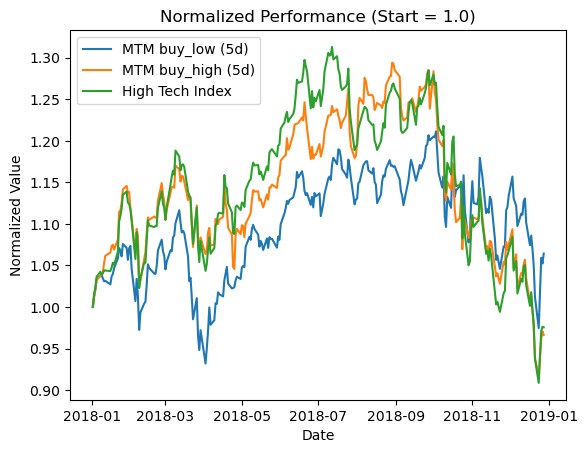

In [19]:
high_tech_index = close_df.mean(axis=1).rename('HighTechIndex')

def norm(s: pd.Series) -> pd.Series:
    return s / s.iloc[0]

plt.figure()
plt.plot(norm(mtm_low_5).index, norm(mtm_low_5).values, label='MTM buy_low (5d)')
plt.plot(norm(mtm_high_5).index, norm(mtm_high_5).values, label='MTM buy_high (5d)')
plt.plot(norm(high_tech_index).index, norm(high_tech_index).values, label='High Tech Index')
plt.title('Normalized Performance (Start = 1.0)')
plt.xlabel('Date'); plt.ylabel('Normalized Value')
plt.legend()
plt.show()

## 5) USDJPY conversion 

In [20]:
def load_usdjpy() -> pd.Series:
    path = find_file_for_key('usdjpy', data_dir)
    fx = smart_read_table(path)

    # Clean column names (remove extra spaces, weird characters)
    fx.columns = [str(c).strip() for c in fx.columns]

    # Try to find the date column
    date_candidates = [c for c in fx.columns if str(c).lower() in ['date', 'datetime', 'time']]
    if not date_candidates:
        # common case: first column is the date but has a weird name like 'Unnamed: 0'
        date_col = fx.columns[0]
    else:
        date_col = date_candidates[0]

    # Try to find a close-like column
    close_candidates = [c for c in fx.columns if 'close' in str(c).lower()]
    if not close_candidates:
        # fallbacks you might see in FX files
        fallbacks = ['price', 'last', 'rate', 'value']
        close_candidates = [c for c in fx.columns if any(f in str(c).lower() for f in fallbacks)]

    if not close_candidates:
        raise ValueError(f"USDJPY: Could not find a Close/Price column. Found columns: {list(fx.columns)}")

    close_col = close_candidates[0]

    fx[date_col] = parse_date_series(fx[date_col])
    fx[close_col] = pd.to_numeric(fx[close_col], errors='coerce')

    fx = fx.dropna(subset=[date_col, close_col]).sort_values(date_col).set_index(date_col)
    fx = fx.loc['2018-01-01':'2018-12-31', [close_col]].dropna()

    return fx[close_col].rename('USDJPY')

## 6) Optimize rebalance interval (1–20 business days)

In [8]:
def optimize_interval(mode: str, min_days: int = 1, max_days: int = 20):
    rows = []
    for d in range(min_days, max_days + 1):
        mtm = run_strategy(d, mode)
        rows.append((d, float(mtm.iloc[-1])))
    return pd.DataFrame(rows, columns=['rebalance_days','final_MTM_USD']).sort_values('final_MTM_USD', ascending=False)

opt_low = optimize_interval('buy_low', 1, 20)
opt_high = optimize_interval('buy_high', 1, 20)

display(opt_low.head(10))
display(opt_high.head(10))

best_low = opt_low.iloc[0]
best_high = opt_high.iloc[0]
best_low, best_high

,rebalance_days,final_MTM_USD
7,8,5.848833e+06
3,4,5.724018e+06
14,15,5.561133e+06
15,16,5.435795e+06
9,10,5.382537e+06
12,13,5.373944e+06
13,14,5.332401e+06
4,5,5.321503e+06
8,9,5.271547e+06
19,20,5.227620e+06


,rebalance_days,final_MTM_USD
10,11,5.427907e+06
11,12,5.419296e+06
0,1,5.283714e+06
6,7,5.213646e+06
5,6,5.185005e+06
2,3,5.164225e+06
18,19,5.040501e+06
1,2,4.976506e+06
8,9,4.932184e+06
16,17,4.911334e+06


(rebalance_days    8.000000e+00
 final_MTM_USD     5.848833e+06
 Name: 7, dtype: float64,
 rebalance_days    1.100000e+01
 final_MTM_USD     5.427907e+06
 Name: 10, dtype: float64)